In [1]:
from __future__ import print_function, division, absolute_import
  
import GPy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import safeopt

mpl.rcParams['figure.figsize'] = (20.0, 10.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 20

## Define a kernel and function

Here we define a kernel. The function is drawn at random from the GP and is corrupted my Gaussian noise

In [2]:
# Measurement noise
noise_var = 0.05 ** 2

# Bounds on the inputs variable
bounds = [(-5., 5.), (-5., 5.)]
parameter_set = safeopt.linearly_spaced_combinations([bounds[0]], 1000)

# Define Kernel
# works on the first column of X, index=0
k_parameters = GPy.kern.RBF(input_dim=1, variance=2., lengthscale=1.0, active_dims=[0])
# works on the second column of X, index=1
k_context = GPy.kern.RBF(input_dim=1, variance=2., lengthscale=1.0, active_dims=[1], name='context')
kernel = k_parameters * k_context

# set of parameters
num_contexts = 1

# Initial safe point
x0 = np.array([[0]])

# Generate function with safe initial point at x=0
def sample_safe_fun(context=0):
    context = np.atleast_2d(context)
    while True:
        # Joint function over parameters and contexts
        sampled_fun = safeopt.sample_gp_function(kernel.copy(), bounds, noise_var, 10)
        
        if sampled_fun(np.hstack([x0, context]), noise=False) > 0.5:
            break
        
    return sampled_fun

In [13]:
def plot(context):
    # Make points transparent when they belong to a different context
    context = np.atleast_2d(context)
    opt.context = context
    
    relevance = opt.gp.kern.context.K(np.hstack([[[0]], context]), opt.gp.X)
    relevance /= opt.gp.kern.context.variance
    relevance = np.exp(100 * relevance) / np.exp(100)
    relevance[relevance < 0.25] = 0.25
    point_color = np.zeros((opt.gp.X.shape[0], 4))
    point_color[:, 3] = relevance
            
    # Plot GP
    opt.plot(n_samples=1000, point_color=point_color)
    
    # Plot the true function
    data = np.concatenate((parameter_set, np.broadcast_to(context, (parameter_set.shape[0], context.shape[1]))), axis=1)
    plt.plot(parameter_set, fun(data, noise=False), color='C2', alpha=0.3)

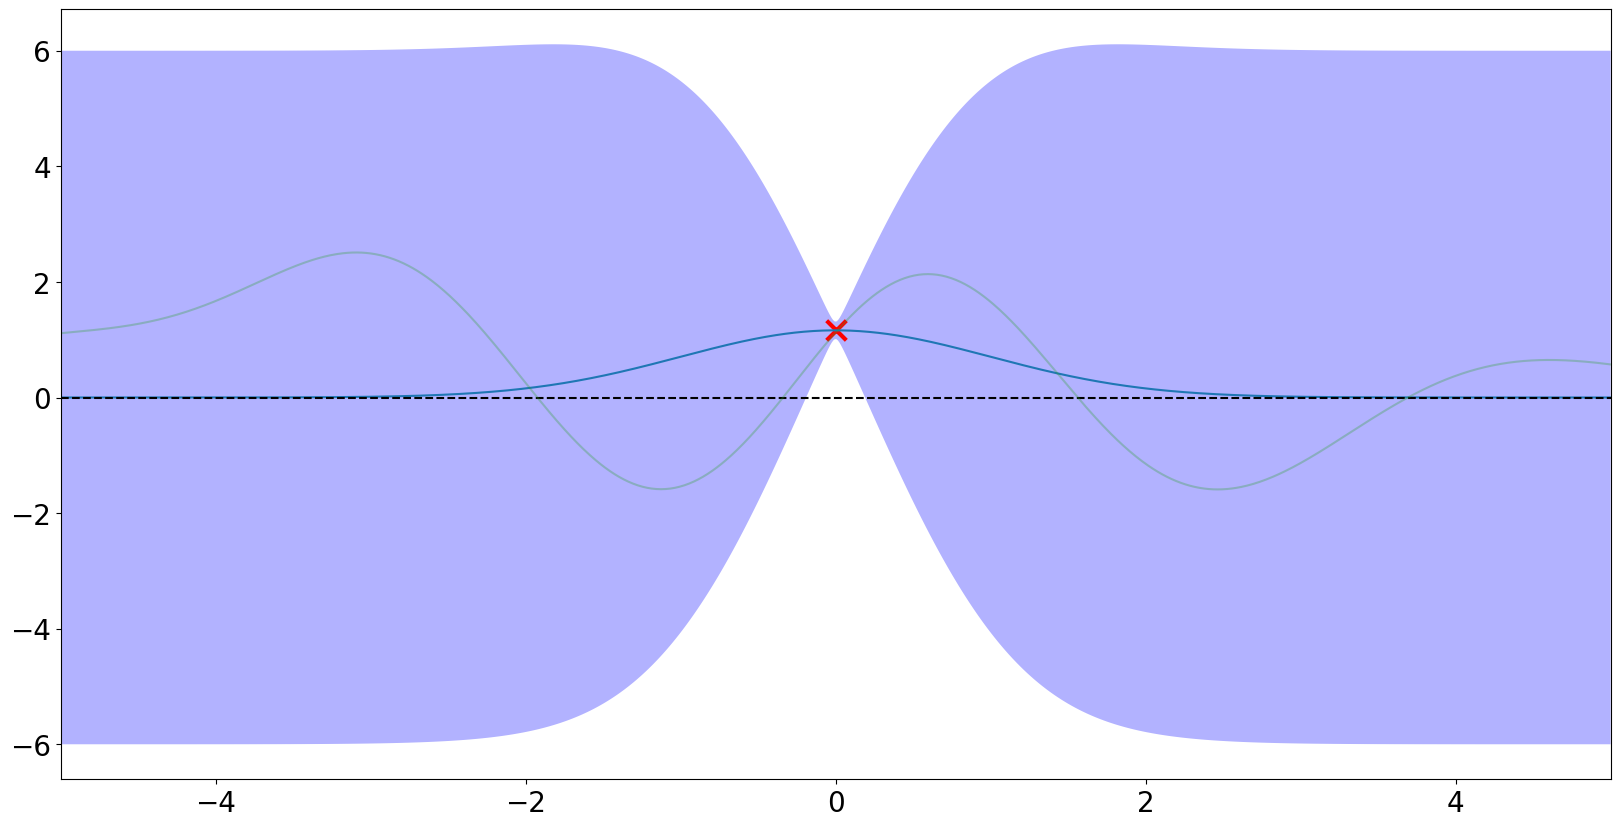

In [12]:
context = np.array([[0]])

# Define the objective function
fun = sample_safe_fun(context)

# The statistical model of our objective function
x = np.hstack([x0, context])
gp = GPy.models.GPRegression(x, fun(x), kernel, noise_var=noise_var)

# The optimization routine
opt = safeopt.SafeOpt(gp, parameter_set, 0., num_contexts=1, threshold=0.5)
opt.context = context

plot(context)

ValueError: 'c' argument has 2 elements, which is inconsistent with 'x' and 'y' with size 1.

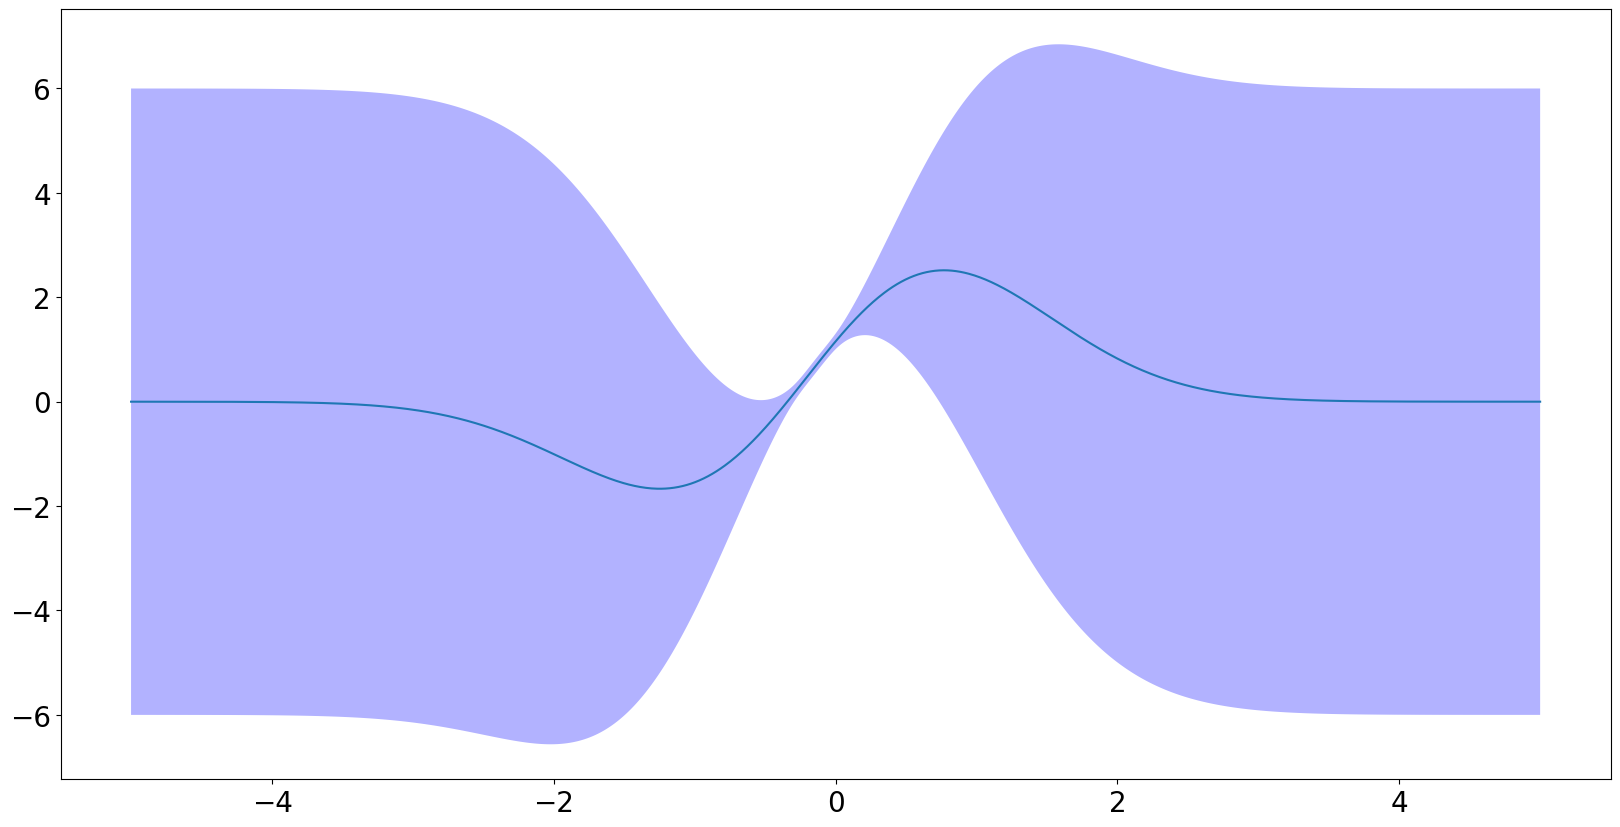

In [14]:
# Obtain next query point
x_next = opt.optimize(context)

# Get a measurement from the real system
y_meas = fun(np.hstack((x_next[None], context)))

# Add this to the GP model
opt.add_new_data_point(x_next, y_meas, context=context)

plot(context=context)

ValueError: 'c' argument has 2 elements, which is inconsistent with 'x' and 'y' with size 1.

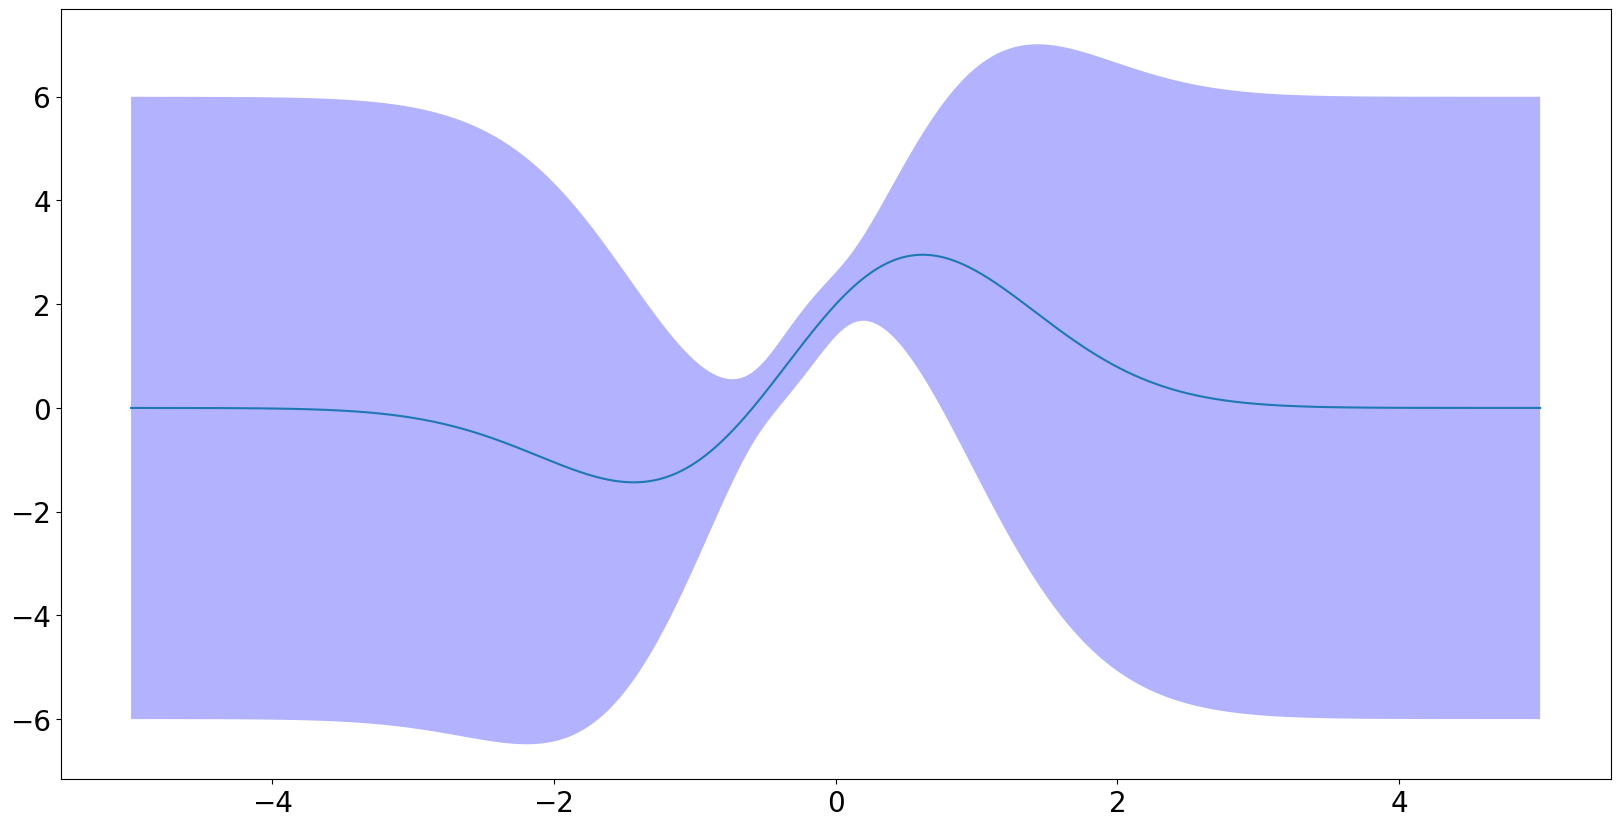

In [9]:
context = np.array([[0.1]])
plot(context)

ValueError: 'c' argument has 3 elements, which is inconsistent with 'x' and 'y' with size 2.

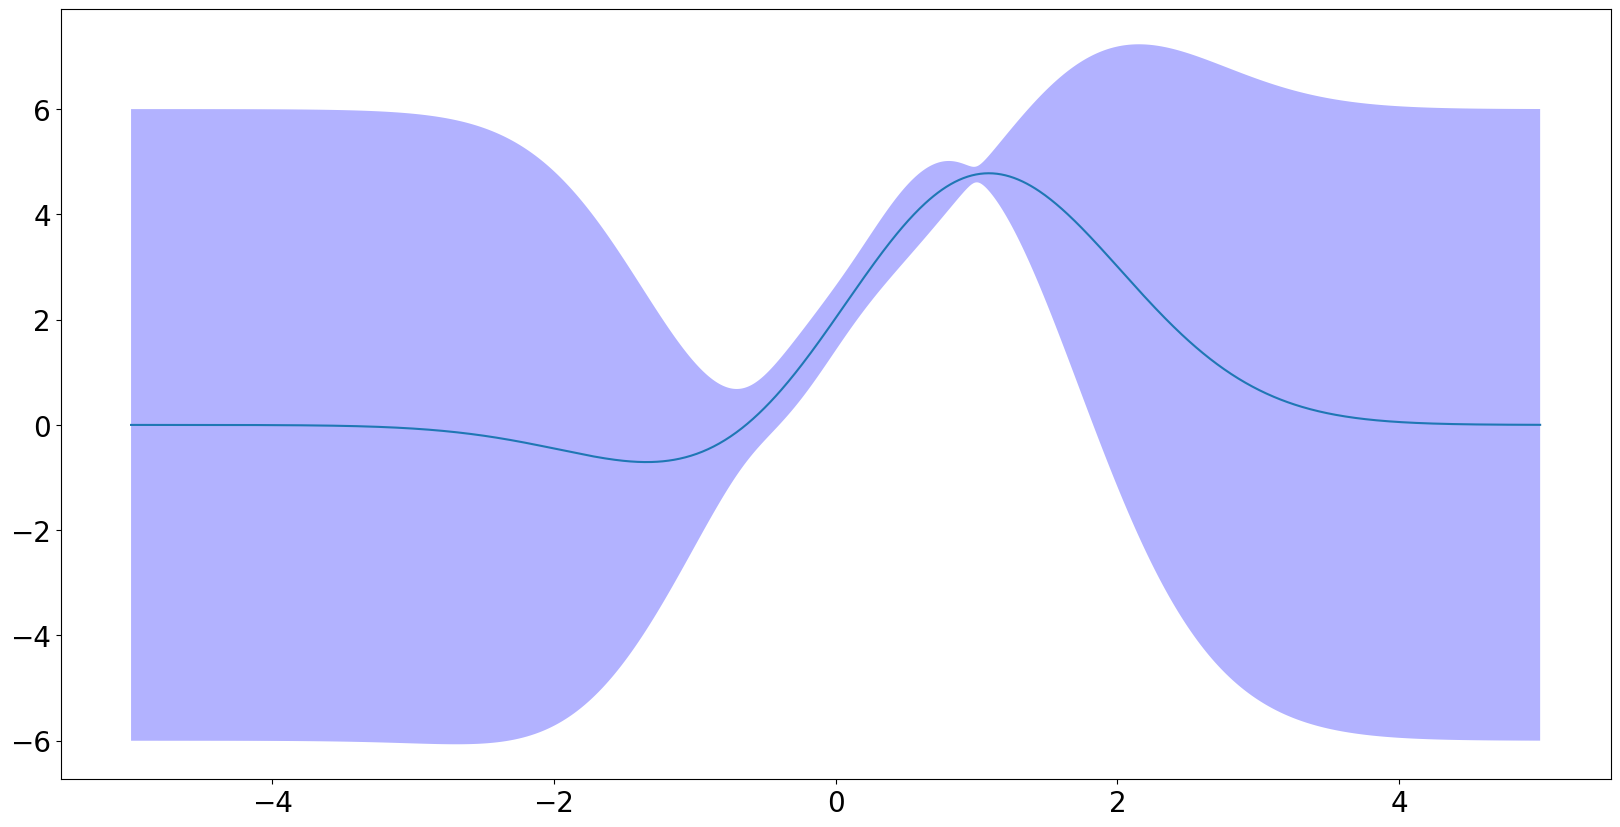

In [10]:
# Obtain next query point
x_next = opt.optimize(context)

# Get a measurement from the real system
y_meas = fun(np.hstack((x_next[None], context)))

# Add this to the GP model
opt.add_new_data_point(x_next, y_meas, context=context)

plot(context=context)